# Saint Venant-Kirchhoff Solid Model

This module provides a testing for the Saint Venant-Kirchhoff solid model, 
which is widely used in the simulation of nonlinear elastic materials.

## References

- T. Belytschko, W. K. Liu, B. Moran, and K. Elkhodary, 
"Nonlinear Finite Elements for Continua and Structures". Wiley, 2014. 
Available: [Google Books](https://books.google.com/books?id=BQpfAQAAQBAJ)

- [Hyperelastic solid on Wikipedia](https://en.wikipedia.org/wiki/Hyperelastic_material)

## Equations

The equation for $\psi$, the strain energy density function, is given by Eq. 5.4.3 in the reference:

$$
\psi = \frac{1}{2} \mathbf{E}:\mathbf{C}:\mathbf{E}
$$

where:

- $\mathbf{E}$ is the Green-Lagrange strain,
- $\mathbf{C}$ is the fourth-order tensor of elastic moduli.


The equation for $S$, the second Piola-Kirchhoff stress, is given by Eq. 5.4.15 in the reference:

$$
S = \lambda \text{ tr}(\mathbf{E})\mathbf{I} + 2\mu\mathbf{E}
$$

where:

- $\mathbf{I}$ is the identity matrix,
- $\lambda$ and $\mu$ are the Lamé constants.

Properties used herein are representative of natural rubber as detailed in the references.

## Setup

In [1]:
# Import necessary libraries
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import subprocess
import yaml

# Define constants
bulk_modulus = 5.0e6  # Pa.
mu = 1.5e6  # Pa.
lame_lambda = bulk_modulus - 2.0 / 3.0 * mu
youngs_modulus = 9.0 * mu * bulk_modulus / (3.0 * bulk_modulus + mu)
poissons_ratio = (3.0 * bulk_modulus - 2.0 * mu) / (2.0 * (3.0 * bulk_modulus + mu))
print(f"Young's modulus: {youngs_modulus/1.0e6} MPa")
print(f"Poisson's ratio: {poissons_ratio}")


# Compute the second Piola-Kirchhoff stress for a given displacement gradient
def compute_second_piola_kirchhoff_stress(du_dX):
    # Compute the deformation gradient
    F = du_dX + np.eye(3)

    # Compute the left Cauchy-Green deformation tensor
    E = 0.5 * (np.dot(F.T, F) - np.eye(3))

    # Compute the second Piola-Kirchhoff stress:w

    S = lame_lambda * np.trace(E) * np.eye(3) + 2.0 * mu * E

    return S


# Create yaml file for running the material_driver
def create_yaml_file(displacement_gradients, yaml_file):
    material = {}
    material["material"] = {}
    material["material"]["elastic"] = {}
    material["material"]["elastic"]["density"] = 1
    material["material"]["elastic"]["youngs_modulus"] = youngs_modulus
    material["material"]["elastic"]["poissons_ratio"] = poissons_ratio
    material["stress_output"] = "cauchy"
    material["displacement_gradients"] = []

    for du_dX in displacement_gradients:
        matrix = []
        row1 = du_dX[0].tolist()
        row2 = du_dX[1].tolist()
        row3 = du_dX[2].tolist()
        material["displacement_gradients"].append({"matrix": [row1, row2, row3]})

    with open(yaml_file, "w") as file:
        yaml.dump(material, file)

    return True


def run_material_driver(driver, yaml_file):
    # Run material_driver and capture the output to a string
    result = subprocess.run([driver, yaml_file], stdout=subprocess.PIPE)
    output = result.stdout.decode("utf-8")

    # Parse the output to get the stress values
    stress_values = []
    for line in output.split("\n"):
        stress = np.zeros((3, 3))
        values = line.split()
        if len(values) != 9:
            continue
        for i in range(3):
            for j in range(3):
                stress[i, j] = float(values[i * 3 + j])
        stress_values.append(stress)

    return stress_values


def check_stress_results(test_stress, gold_stress):
    # Check if the number of stress values match
    checks_passed = True
    message = ""
    if len(test_stress) != len(gold_stress):
        message += f"Error: Number of stress values do not match. Expected: {len(gold_stress)}, Actual: {len(test_stress)}\n"
        checks_passed = False
        return checks_passed, message

    # Compare the stress values
    relative_tolerance = 1.0e-5
    cuttoff_stress_magnitude = 1.0e-3
    for k in range(len(test_stress)):
        for i in range(3):
            for j in range(3):
                absolute_tolerance = relative_tolerance * np.abs(gold_stress[k][i, j])
                if np.abs(gold_stress[k][i, j]) < cuttoff_stress_magnitude:
                    absolute_tolerance = relative_tolerance
                if (
                    np.abs(test_stress[k][i, j] - gold_stress[k][i, j])
                    > absolute_tolerance
                ):
                    message += f"Error: Stress values do not match. Expected: {gold_stress[k][i,j]}, Actual: {test_stress[k][i,j]}\n"
                    checks_passed = False

    return checks_passed, message

Young's modulus: 4.090909090909091 MPa
Poisson's ratio: 0.36363636363636365


## Examples / Tests

### Uniaxial tension

With uniaxial tension, we can solve for $\lambda_2$ as a function of $\lambda_1$, giving everything needed to solve for the second Piola-Kirchhoff stress, $\mathbf{S}$

We have:

$$
S_{11} = \lambda_0 \text{ tr}(\mathbf{E}) + 2 \mu_0 E_{11} \neq 0.0
$$

and:

$$
S_{22} = \lambda_0 \text{ tr}(\mathbf{E}) + 2 \mu_0 E_{22} = 0.0
$$

$$
S_{33} = \lambda_0 \text{ tr}(\mathbf{E}) + 2 \mu_0 E_{33} = 0.0
$$

$$
S_{12} = S_{13} = S_{23} = 0.0
$$

where:
- $S_{ij}$ is the second Piola-Kirchhoff stress tensor
- $\lambda_1$ is the stretch in the 1-direction,
- $\mu_0$ is the shear modulus,
- $\lambda_0$ is the first Lamé parameter.

The deformation gradient tensor is:

$$
F = \text{diag}(\lambda_1, \lambda_2, \lambda_2)
$$

The Green-Lagrange strain tensor is:

$$
\mathbf{E} = \frac{1}{2} \begin{bmatrix} \lambda_1^2-1 & 0.0 & 0.0 \\ 0.0 & \lambda_2^2-1 & 0.0 \\ 0.0 & 0.0 & \lambda_2^2-1 \end{bmatrix}
$$

Since $S_{22} = S_{33} = 0$ and $E_{22} = E_{33}$ we can solve:

$$
S_{22} = 0 = \lambda_0 (E_{11} + 2 E_{22}) + 2 \mu E_{22}
$$

$$
\lambda_0 E_{11} = - 2(\mu + \lambda_0) E_{22}
$$

$$
\frac{-\lambda_0}{2(\mu + \lambda_0) } E_{11} = E_{22}
$$

and

$$
\frac{-\lambda_0}{2(\mu + \lambda_0) } (\lambda_1^2-1) = \lambda_2^2-1
$$

$$
\sqrt{1 - \frac{\lambda_0}{2(\mu + \lambda_0) } (\lambda_1^2-1)} = \lambda_2
$$

The deformation gradient, Green-Lagrange strain, and finally second Piola-Kirchhoff stress can then be calculated using $\lambda_1$ and $\lambda_2$


In [2]:
# Function to compute the Cauchy stress and infinitesimal strain for a given stretch
def compute_stress_for_uniaxial_tension(lambda_1):
    # Compute the stretch in the other two directions
    lambda_2 = np.sqrt(
        1.0 - lame_lambda / (2.0 * (mu + lame_lambda)) * (lambda_1**2 - 1.0)
    )

    # Compute the deformation gradient
    F = np.diag([lambda_1, lambda_2, lambda_2])

    # Compute the displacement gradient
    du_dX = F - np.eye(3)

    # Compute the second Piola-Kirchhoff stress
    S = compute_second_piola_kirchhoff_stress(du_dX)

    # Compute the Cauchy stress
    sigma = np.dot(F, np.dot(S, F.T)) / np.linalg.det(F)

    # Make sure all components of tau except tau_11 are zero
    for i in range(3):
        for j in range(3):
            if i == 0 and j == 0:
                continue
            if np.abs(S[i, j]) > 1.0e-8 * np.abs(S[0, 0]):
                print(f"Warning: S[{i}, {j}] is not zero. Value: {S[i, j]}")

    # Compute the infinitesimal strain tensor
    epsilon = 0.5 * (du_dX + du_dX.T)

    return du_dX, epsilon, sigma


# Compute the stress and strain for a range of stretch ratios
def sweep_lambda_for_uniaxial_tension():
    lambda_1 = np.linspace(0.1, 1.5, 99)
    infinitesimal_strain = []
    sigma = []
    displacement_gradients = []

    for l in lambda_1:
        du_dX, e, s = compute_stress_for_uniaxial_tension(l)
        infinitesimal_strain.append(e)
        sigma.append(s)
        displacement_gradients.append(du_dX)

    return lambda_1, displacement_gradients, infinitesimal_strain, sigma


def run_uniaxial_test(driver="material_driver", yaml_file="material_driver.yaml"):
    message = "Running uniaxial test"
    try:
        lambda_1, displacement_gradients, infinitesimal_strain, sigma = (
            sweep_lambda_for_uniaxial_tension()
        )
        message += " - completed sweep of lambda values\n"

        create_yaml_file(displacement_gradients, yaml_file)
        message += " - created yaml file: {}\n".format(yaml_file)

        test_stress = run_material_driver(driver, yaml_file)
        message += " - ran material_driver: {}\n".format(driver)

        gold_stress = sigma
        checks_passed, msg = check_stress_results(test_stress, gold_stress)
        message += " - checked results\n"
        message += msg

        if not checks_passed:
            message += " - test failed due to mismatch in stress values\n"
        return checks_passed, message
    except Exception as e:
        message += " - test failed with exception: " + str(e)
        return False, message

[Jakes-MacBook-Pro.local:69634] shmem: mmap: an error occurred while determining whether or not /var/folders/xr/3d5xjd5d4736tpyqkdlqgvkh0000gn/T//ompi.Jakes-MacBook-Pro.501/jf.0/2633629696/sm_segment.Jakes-MacBook-Pro.501.9cfa0000.0 could be created.


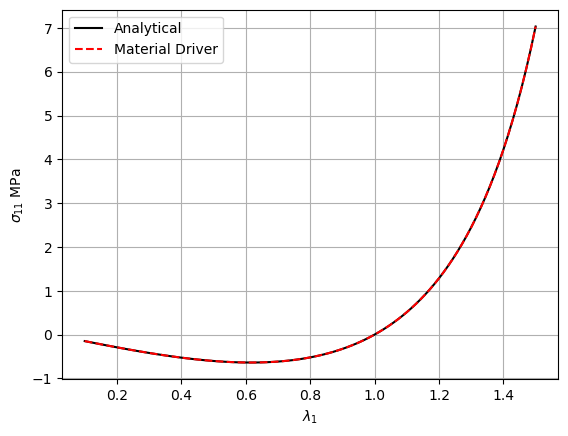

In [3]:
from IPython.display import SVG

# Sweep the stretch ratio for uniaxial tension
lambda_1, du_dX, _infinitesimal_strain, sigma = sweep_lambda_for_uniaxial_tension()
create_yaml_file(du_dX, "temp.yaml")
sigma_material_driver = run_material_driver(
    "../../build/Release/material_driver", "temp.yaml"
)

sigma_11 = [s[0, 0] / 1.0e6 for s in sigma]
sigma_material_driver_11 = [s[0, 0] / 1.0e6 for s in sigma_material_driver]

# Plot the results, lambda_1 vs sigma_11
plt.plot(lambda_1, sigma_11, color="black", label="Analytical")
plt.plot(
    lambda_1,
    sigma_material_driver_11,
    color="red",
    linestyle="--",
    label="Material Driver",
)
plt.xlabel("$\\lambda_{1}$")
plt.ylabel("$\\sigma_{11}$ MPa")
plt.legend()
plt.grid()

plt.show()


### Simple Shear

With simple shear we have:

$$
\mathbf{F} = \begin{bmatrix} 1 & \gamma & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{bmatrix}
$$

$$
\mathbf{E} = \frac{1}{2}\left(\mathbf{F}^T\mathbf{F}\right)-\mathbf{I} = \frac{1}{2} \begin{bmatrix} 0 & \gamma & 0 \\ \gamma & \gamma^2 & 0 \\ 0 & 0 & 0 \end{bmatrix}
$$

and, again, the equation for $S$, the second Piola-Kirchhoff stress, is given by Eq. 5.4.15 in the reference:

$$
S = \lambda_0 \text{ tr}(\mathbf{E})\mathbf{I} + 2\mu\mathbf{E}
$$

and thus

$$
S_{11} = S_{33} = \frac{\lambda_0 \gamma^2}{2}
$$

$$
S_{22} = (\frac{1}{2} \lambda_0 + \mu_0) \gamma^2
$$

$$
S_{12} = S_{21} = \mu_0 \gamma
$$

with other components equal to zero.

In [4]:
# Function to compute the Cauchy stress and infinitesimal strain for a given shear
def compute_stress_for_simple_shear(gamma):

    # Compute the displacement gradient
    du_dX = np.zeros((3, 3))
    du_dX[0, 1] = gamma

    # Compute the deformation gradient
    F = np.eye(3) + du_dX

    # Compute the Kirchhoff stress
    S = compute_second_piola_kirchhoff_stress(du_dX)

    # Compute the Cauchy stress
    sigma = np.dot(F, np.dot(S, F.T)) / np.linalg.det(F)

    # Check that S is as expected
    expected_S = np.zeros((3, 3))
    expected_S[1, 1] = (0.5 * lame_lambda + mu) * gamma**2
    expected_S[0, 0] = expected_S[2, 2] = 0.5 * lame_lambda * gamma**2
    expected_S[0, 1] = mu * gamma
    expected_S[1, 0] = mu * gamma

    for i in range(3):
        for j in range(3):
            if np.abs(S[i, j] - expected_S[i, j]) > 1.0e-8:
                print(
                    f"Warning: S[{i},{j}] is not as expected. Expected: {expected_S[i,j]}, Actual: {S[i,j]}"
                )

    # Compute the infinitesimal strain tensor
    epsilon = 0.5 * (du_dX + du_dX.T)

    return du_dX, epsilon, sigma


# Compute the stress and strain for a range of shear values
def sweep_gamma_for_simple_shear():
    gamma = np.linspace(0.0, 2.0, 100)
    infinitesimal_strain = []
    sigma = []
    displacement_gradients = []

    for g in gamma:
        du_dX, e, s = compute_stress_for_simple_shear(g)
        infinitesimal_strain.append(e)
        sigma.append(s)
        displacement_gradients.append(du_dX)

    return gamma, displacement_gradients, infinitesimal_strain, sigma


def run_simple_shear_test(
    driver="material_driver", yaml_file="material_driver_st_venant_kirchhoff.yaml"
):
    message = "Running simple shear test"
    try:
        gamma, displacement_gradients, infinitesimal_strain, sigma = (
            sweep_gamma_for_simple_shear()
        )
        message += " - completed sweep of gamma values\n"

        create_yaml_file(displacement_gradients, yaml_file)
        message += " - created yaml file: {}\n".format(yaml_file)

        test_stress = run_material_driver(driver, yaml_file)
        message += " - ran material_driver: {}\n".format(driver)

        gold_stress = sigma
        checks_passed, msg = check_stress_results(test_stress, gold_stress)
        message += " - checked results\n"
        message += msg

        if not checks_passed:
            message += " - test failed due to mismatch in stress values\n"
        return checks_passed, message
    except Exception as e:
        message += " - test failed with exception: " + str(e)
        return False, message

[Jakes-MacBook-Pro.local:70308] shmem: mmap: an error occurred while determining whether or not /var/folders/xr/3d5xjd5d4736tpyqkdlqgvkh0000gn/T//ompi.Jakes-MacBook-Pro.501/jf.0/3821666304/sm_segment.Jakes-MacBook-Pro.501.e3ca0000.0 could be created.


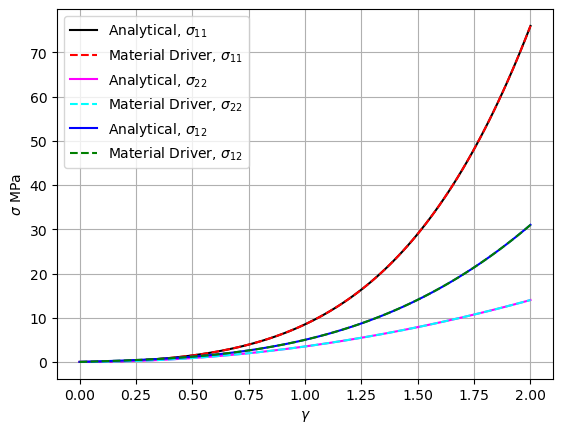

In [7]:
from IPython.display import SVG

# Sweep the gamma values for simple shear
gamma, du_dX, _infinitesimal_strain, sigma = sweep_gamma_for_simple_shear()
create_yaml_file(du_dX, "temp.yaml")
sigma_material_driver = run_material_driver(
    "../../build/Release/material_driver", "temp.yaml"
)

sigma_11 = [s[0, 0] / 1.0e6 for s in sigma]
sigma_material_driver_11 = [s[0, 0] / 1.0e6 for s in sigma_material_driver]

sigma_22 = [s[1, 1] / 1.0e6 for s in sigma]
sigma_material_driver_22 = [s[1, 1] / 1.0e6 for s in sigma_material_driver]

sigma_12 = [s[0, 1] / 1.0e6 for s in sigma]
sigma_material_driver_12 = [s[0, 1] / 1.0e6 for s in sigma_material_driver]

# Plot the results, gamma, vs sigma_11
plt.plot(gamma, sigma_11, color="black", label="Analytical, $\\sigma_{11}$")
plt.plot(
    gamma,
    sigma_material_driver_11,
    color="red",
    linestyle="--",
    label="Material Driver, $\\sigma_{11}$",
)
# Plot the results, gamma, vs sigma_22
plt.plot(gamma, sigma_22, color="magenta", label="Analytical, $\\sigma_{22}$")
plt.plot(
    gamma,
    sigma_material_driver_22,
    color="cyan",
    linestyle="--",
    label="Material Driver, $\\sigma_{22}$",
)
# Plot the results, gamma, vs sigma_12
plt.plot(gamma, sigma_12, color="blue", label="Analytical, $\\sigma_{12}$")
plt.plot(
    gamma,
    sigma_material_driver_12,
    color="green",
    linestyle="--",
    label="Material Driver, $\\sigma_{12}$",
)
plt.xlabel("$\\gamma$")
plt.ylabel("$\\sigma$ MPa")
plt.legend()
plt.grid()

plt.show()